<a href="https://colab.research.google.com/github/williambiondi/RecommenderGS/blob/main/recommenderGranSasso.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importazione dei dati e librerie


In [1]:
!pip install tensorflow -q
!pip install transformers -q
!pip install tensorflow-recommenders -q
!pip install keras-tuner -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.2/96.2 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 1.5 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_recommenders as tfrs
from transformers import DistilBertTokenizer, TFDistilBertModel
from IPython import display
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
import re
from keras_tuner import HyperModel
from kerastuner.tuners import RandomSearch


<ipython-input-2-ea52cb71ca94>:11: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


#Caricamento dati

In [3]:
items = pd.read_csv('https://raw.githubusercontent.com/williambiondi/RecommenderGS/main/ArticoliGransasso.csv')
customers = pd.read_csv('https://raw.githubusercontent.com/williambiondi/RecommenderGS/main/ClientiGransasso.csv')
purchases = pd.read_csv('https://raw.githubusercontent.com/williambiondi/RecommenderGS/main/OrdiniGransasso.csv')

In [4]:
items.drop(columns=['Unnamed: 0'], inplace=True)
customers.drop(columns=['Unnamed: 0'], inplace=True)
purchases.drop(columns=['Unnamed: 0'], inplace=True)

#Preparazione dati per modello


Annoto come interazione positiva (1) tutti gli articoli acquistati, come interazione negativa (-1) tutti gli articoli rimborsati

In [5]:
interactions = [1 if row['RefundedEUR'] == 0 else -1 for _,row in purchases.iterrows()]
purchases["Interaction"] = interactions

In [6]:
text_combined = []
for idx, row in items.iterrows():
  descriptive = row['ItemName'].lower()+" "+row['Description']
  text_combined.append(descriptive)
items['TextInfo'] = text_combined

In [7]:
len_desc = [len(row['TextInfo'].split(" ")) for _,row in items.iterrows()]
max(len_desc)

190

In [40]:
items = items[items['Availability']==1].reset_index()

Utilizzo DistilBERT per ottenere gli embeddings di tutta l'informazione testuale degli articoli (nome articolo e descrizione)

In [11]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
enc_input = tokenizer(items['TextInfo'].tolist(),
                      padding=True,
                      truncation=True,
                      max_length=150,
                      return_tensors='tf')

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [12]:
distilbert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [13]:
outputs = distilbert_model(enc_input)
embeddings = outputs.last_hidden_state

In [14]:
embeddings_np = embeddings.numpy()
summary_embeddings = embeddings_np[:,0,:]
df_embeddings = pd.DataFrame(summary_embeddings)
df_embeddings.columns = [f'embedding_{i}' for i in range(df_embeddings.shape[1])]

In [15]:
df_embeddings.head()

,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,embedding_9,...,embedding_758,embedding_759,embedding_760,embedding_761,embedding_762,embedding_763,embedding_764,embedding_765,embedding_766,embedding_767
0,-0.108161,-0.68033,-0.080138,-0.010965,0.358875,-0.145106,0.08981,0.258709,-0.293660,-0.194106,...,-0.156831,-0.502822,0.177608,-0.451766,-0.024967,-0.193190,-0.093536,-0.280294,0.134717,-0.269296
1,-0.108161,-0.68033,-0.080138,-0.010965,0.358875,-0.145106,0.08981,0.258709,-0.293660,-0.194106,...,-0.156831,-0.502822,0.177608,-0.451766,-0.024967,-0.193190,-0.093536,-0.280294,0.134717,-0.269296
2,-0.129649,-0.53888,0.352004,-0.212883,0.033437,-0.145572,0.21726,0.155418,-0.005949,-0.091336,...,0.081107,-0.395429,-0.079735,-0.381244,0.099102,-0.264978,-0.055354,-0.204596,0.126875,-0.111216
3,-0.129649,-0.53888,0.352004,-0.212883,0.033437,-0.145572,0.21726,0.155418,-0.005949,-0.091336,...,0.081107,-0.395429,-0.079735,-0.381244,0.099102,-0.264978,-0.055354,-0.204596,0.126875,-0.111216
4,-0.129649,-0.53888,0.352004,-0.212883,0.033437,-0.145572,0.21726,0.155418,-0.005949,-0.091336,...,0.081107,-0.395429,-0.079735,-0.381244,0.099102,-0.264978,-0.055354,-0.204596,0.126875,-0.111216


#PCA

Riduco gli embeddings

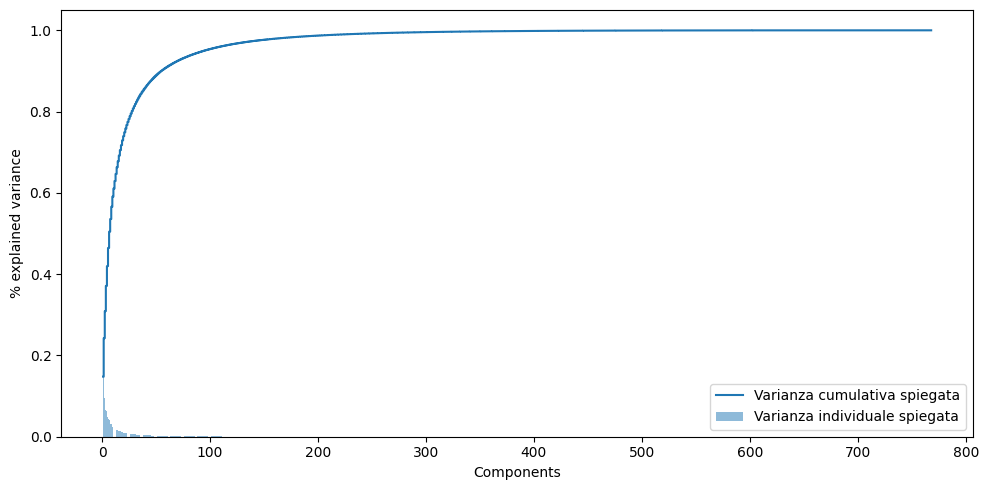

In [ ]:
pca = PCA()
pca.fit(df_embeddings)

explained = pca.explained_variance_ratio_
cumulative = np.cumsum(explained)

n_components = np.where(cumulative>=0.95)[0][0]+1

plt.figure(figsize=(10, 5))
plt.bar(range(1, len(explained) + 1), explained, alpha=0.5, align='center', label='Varianza individuale spiegata')
plt.step(range(1, len(cumulative) + 1), cumulative, where='mid', label='Varianza cumulativa spiegata')
plt.ylabel('% explained variance')
plt.xlabel('Components')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [ ]:
pca = PCA(n_components=n_components)
reduced = pca.fit_transform(df_embeddings)
df_reduced = pd.DataFrame(reduced, columns = [f"pc_{i}" for i in range(reduced.shape[1])])

In [ ]:
df_reduced['ItemId'] = items['ItemId']

In [ ]:
df_reduced.head()

,pc_0,pc_1,pc_2,pc_3,pc_4,pc_5,pc_6,pc_7,pc_8,pc_9,...,pc_86,pc_87,pc_88,pc_89,pc_90,pc_91,pc_92,pc_93,pc_94,ItemId
0,0.432970,-0.214806,-0.676683,0.242818,-0.502649,0.213220,0.044391,-0.406389,0.119929,0.290795,...,0.056196,-0.075866,0.059007,-0.040150,0.103424,0.022511,-0.062532,-0.008932,0.036174,0
1,-1.344923,-0.502456,-0.108875,-0.200827,-0.811736,-0.145801,-0.138471,-0.102809,0.132498,-0.286610,...,-0.084468,0.040849,-0.116503,-0.068888,0.126376,0.072122,0.097351,-0.026363,0.077163,1
2,-0.508014,0.428694,-0.924211,-0.456853,-0.142499,-0.227780,0.160290,0.145653,-0.215662,-0.172427,...,-0.073623,-0.090369,0.068430,-0.078839,-0.051480,-0.004852,0.045254,0.000644,-0.035522,2
3,0.467723,0.633642,-0.853467,0.216090,-0.056622,-0.370798,-0.207283,0.360090,0.606439,0.535531,...,0.116651,-0.116166,-0.030867,0.016824,0.250133,0.056755,0.072139,0.063508,0.121616,3
4,1.449940,0.353150,-0.104016,-0.192967,-0.214779,-0.368194,-0.541566,0.426434,0.140475,0.117268,...,0.056094,-0.070079,-0.078324,-0.028312,0.021881,0.077104,-0.071455,0.095920,0.033813,4


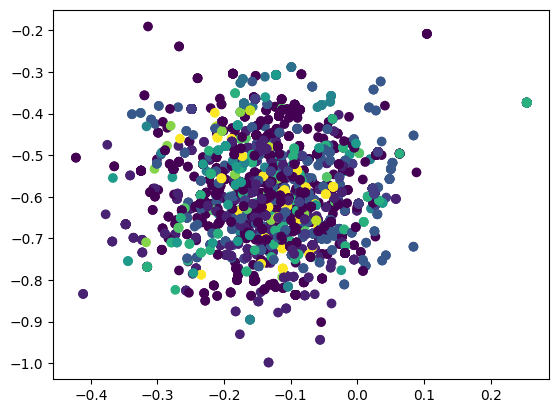

In [ ]:
plt.scatter(df_embeddings.iloc[:,0], df_embeddings.iloc[:,1], c =c)

In [ ]:
items.shape

(3497, 13)

In [ ]:
df_reduced.shape

(3497, 96)

In [ ]:
import json
def try_catch(fn, *args):
  try:
    return fn(*args)
  except:
    return ' '
cats = items.Category.apply(lambda x: try_catch(eval,x)[0])
unique = cats.unique().tolist()
c = [unique.index(_) for _ in cats]

In [ ]:
df_embeddings['ItemId'] = items['ItemId']

In [ ]:
full_items = items.merge(df_reduced, on='ItemId')

In [ ]:
df_full = full_items.merge(purchases, on='ItemId')

In [ ]:
df_full

,Sku,ItemName,Category,UnitPrice,ItemId,Collection,Availability,Color,Gender,Description,...,embedding_764,embedding_765,embedding_766,embedding_767,Id,UserId,CreatedOnUtc,RefundedEUR,UnitPriceTaxEUR,Interaction
0,A20205716614238589,MICRO RHOMBUS STITCH CREW NECK,['Maglieria'],130.0,0,Fall-Winter,0,589,Men,crew neck sweater in pure merino wool with mic...,...,-0.110403,-0.167462,0.064619,-0.084191,8812,0,2021-01-01 09:29:05.2513839,0.0,130.0,1
1,A20205716614238589,MICRO RHOMBUS STITCH CREW NECK,['Maglieria'],130.0,0,Fall-Winter,0,589,Men,crew neck sweater in pure merino wool with mic...,...,-0.110403,-0.167462,0.064619,-0.084191,8860,47,2021-01-03 23:11:34.9635880,0.0,130.0,1
2,A20205716614238589,MICRO RHOMBUS STITCH CREW NECK,['Maglieria'],130.0,0,Fall-Winter,0,589,Men,crew neck sweater in pure merino wool with mic...,...,-0.110403,-0.167462,0.064619,-0.084191,9311,413,2021-02-13 12:39:33.7391675,0.0,130.0,1
3,A20205716614238589,MICRO RHOMBUS STITCH CREW NECK,['Maglieria'],130.0,0,Fall-Winter,0,589,Men,crew neck sweater in pure merino wool with mic...,...,-0.110403,-0.167462,0.064619,-0.084191,9772,276,2021-04-10 11:33:22.9952881,0.0,130.0,1
4,A20201312414230005,WAVE PATTERN TURTLENECK,['Maglieria'],160.0,1,Fall-Winter,0,5,Men,turtleneck sweater in pure merino wool embelli...,...,-0.089355,-0.199527,0.250173,-0.131352,8813,1,2021-01-01 09:39:57.3829465,0.0,160.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19867,A20231312622601465,AIR WOOL TURTLE NECK,['Maglieria'],200.0,3492,Fall-Winter,1,465,Men,air wool turtleneck the special feature of thi...,...,-0.190599,-0.120545,0.153098,0.118914,19639,956,2023-10-30 09:41:32.5978041,0.0,200.0,1
19868,A20231312622601661,AIR WOOL TURTLE NECK,['Maglieria'],200.0,3493,Fall-Winter,1,661,Men,air wool turtleneck the special feature of thi...,...,-0.190599,-0.120545,0.153098,0.118914,19639,956,2023-10-30 09:41:32.5978041,0.0,200.0,1
19869,A20232311825022098,WOOL JACKET WITH ECO-PADDING,"['Capispalla', 'Maglieria']",460.0,3494,Fall-Winter,1,98,Men,super geelong wool bomber jacket the front is ...,...,-0.227826,-0.067119,0.025371,-0.009382,19640,5242,2023-10-30 13:38:18.8120889,1400.0,460.0,-1
19870,A20232312519621039,2-PLY CASHMERE BLEND MOCK ZIP,['Maglieria'],245.0,3495,Fall-Winter,1,39,Men,2ply mock zip sweater cashmere blend an evergr...,...,-0.088379,-0.283592,0.293171,-0.085258,19640,5242,2023-10-30 13:38:18.8120889,1400.0,245.0,-1


#Training w/o PCA

In [41]:
items['ItemId']

0      2112
1      2168
2      2509
3      2510
4      2511
       ... 
973    3492
974    3493
975    3494
976    3495
977    3496
Name: ItemId, Length: 978, dtype: int64

In [44]:
df_embeddings['ItemId'] = items['ItemId']

In [45]:
df_embeddings

,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,embedding_9,...,embedding_759,embedding_760,embedding_761,embedding_762,embedding_763,embedding_764,embedding_765,embedding_766,embedding_767,ItemId
0,-0.108161,-0.680330,-0.080138,-0.010965,0.358875,-0.145106,0.089810,0.258709,-0.293660,-0.194106,...,-0.502822,0.177608,-0.451766,-0.024967,-0.193190,-0.093536,-0.280294,0.134717,-0.269296,2112
1,-0.108161,-0.680330,-0.080138,-0.010965,0.358875,-0.145106,0.089810,0.258709,-0.293660,-0.194106,...,-0.502822,0.177608,-0.451766,-0.024967,-0.193190,-0.093536,-0.280294,0.134717,-0.269296,2168
2,-0.129649,-0.538880,0.352004,-0.212883,0.033437,-0.145572,0.217260,0.155418,-0.005949,-0.091336,...,-0.395429,-0.079735,-0.381244,0.099102,-0.264978,-0.055354,-0.204596,0.126875,-0.111216,2509
3,-0.129649,-0.538880,0.352004,-0.212883,0.033437,-0.145572,0.217260,0.155418,-0.005949,-0.091336,...,-0.395429,-0.079735,-0.381244,0.099102,-0.264978,-0.055354,-0.204596,0.126875,-0.111216,2510
4,-0.129649,-0.538880,0.352004,-0.212883,0.033437,-0.145572,0.217260,0.155418,-0.005949,-0.091336,...,-0.395429,-0.079735,-0.381244,0.099102,-0.264978,-0.055354,-0.204596,0.126875,-0.111216,2511
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
973,-0.119304,-0.479349,0.170073,-0.028873,0.044244,-0.102208,0.118208,0.411626,-0.298964,-0.299853,...,-0.545233,0.238014,-0.373455,0.000430,-0.258044,-0.190599,-0.120545,0.153098,0.118914,3492
974,-0.119304,-0.479349,0.170073,-0.028873,0.044244,-0.102208,0.118208,0.411626,-0.298964,-0.299853,...,-0.545233,0.238014,-0.373455,0.000430,-0.258044,-0.190599,-0.120545,0.153098,0.118914,3493
975,-0.174643,-0.565569,0.043599,-0.019245,0.087999,-0.120272,0.178637,0.132949,-0.020929,-0.254734,...,-0.660405,0.082192,-0.521257,-0.007587,-0.169488,-0.227826,-0.067119,0.025371,-0.009382,3494
976,-0.142700,-0.677479,0.111383,-0.101643,0.021571,-0.027906,0.196382,0.246792,0.049769,-0.125597,...,-0.426514,0.028916,-0.281658,0.073952,-0.222323,-0.088379,-0.283592,0.293171,-0.085258,3495


In [46]:
full_items = items.merge(df_embeddings, on='ItemId')

In [47]:
df_full = full_items.merge(purchases, on='ItemId')

In [60]:
user_id_mapping = {old_id: new_id for new_id, old_id in enumerate(df_full['UserId'].unique())}
df_full['UserId'] = df_full['UserId'].map(user_id_mapping)

In [61]:
df_full.head()

,index,Sku,ItemName,Category,UnitPrice,ItemId,Collection,Availability,Color,Gender,...,embedding_764,embedding_765,embedding_766,embedding_767,Id,UserId,CreatedOnUtc,RefundedEUR,UnitPriceTaxEUR,Interaction
0,2112,P20236013374002598,MERCERIZED COTTON T-SHIRT,"['Polo, Camicie e T-shirt']",110.0,2112,Spring-Summer,1,598,Men,...,-0.093536,-0.280294,0.134717,-0.269296,14654,0,2022-10-05 06:57:58.6130257,2510.0,110.00,-1
1,2112,P20236013374002598,MERCERIZED COTTON T-SHIRT,"['Polo, Camicie e T-shirt']",110.0,2112,Spring-Summer,1,598,Men,...,-0.093536,-0.280294,0.134717,-0.269296,14654,0,2022-10-05 06:57:58.6130257,2510.0,110.00,-1
2,2112,P20236013374002598,MERCERIZED COTTON T-SHIRT,"['Polo, Camicie e T-shirt']",110.0,2112,Spring-Summer,1,598,Men,...,-0.093536,-0.280294,0.134717,-0.269296,14831,1,2022-10-21 08:52:47.7390795,0.0,90.16,1
3,2112,P20236013374002598,MERCERIZED COTTON T-SHIRT,"['Polo, Camicie e T-shirt']",110.0,2112,Spring-Summer,1,598,Men,...,-0.093536,-0.280294,0.134717,-0.269296,14832,2,2022-10-21 09:55:27.4071960,0.0,110.00,1
4,2112,P20236013374002598,MERCERIZED COTTON T-SHIRT,"['Polo, Camicie e T-shirt']",110.0,2112,Spring-Summer,1,598,Men,...,-0.093536,-0.280294,0.134717,-0.269296,14838,3,2022-10-21 15:28:52.1920326,0.0,110.00,1


In [62]:
data_tf = tf.data.Dataset.from_tensor_slices({
    "user_id": df_full['UserId'].values.reshape(-1,1),
    "item_id": df_full['ItemId'].values.reshape(-1,1),
    "item_embedding" : df_full[[f'embedding_{i}' for i in range(df_embeddings.shape[1]-1)]].values
})
candidates_tf = tf.data.Dataset.from_tensor_slices({
    "item_id": full_items['ItemId'].values.reshape(-1,1),
    "item_embedding" : full_items[[f'embedding_{i}' for i in range(df_embeddings.shape[1]-1)]].values
})
candidates_ds = candidates_tf.batch(32)

In [26]:
data_tf

<_ShuffleDataset element_spec={'user_id': TensorSpec(shape=(1,), dtype=tf.int64, name=None), 'item_id': TensorSpec(shape=(1,), dtype=tf.int64, name=None), 'item_embedding': TensorSpec(shape=(768,), dtype=tf.float32, name=None)}>

In [63]:
data_tf = data_tf.shuffle(buffer_size=1024, seed = 999, reshuffle_each_iteration = False)
full_size = len(data_tf)
train_size = int(full_size * 0.8)
val_size = int(train_size * 0.2)
train_size -= val_size

train = data_tf.take(train_size)
rest = data_tf.skip(train_size)
val = rest.take(val_size)
test = rest.skip(val_size)

In [64]:
batch_size = 32
train = train.shuffle(buffer_size=1024, seed = 999).batch(batch_size)
test = test.batch(batch_size)
val = val.batch(batch_size)

In [52]:
for features in train.take(1):
    print("User ID Shape in Train:", features["user_id"].shape)
    print("Item Embedding Shape in Train:", features["item_embedding"].shape)

User ID Shape in Train: (32, 1)
Item Embedding Shape in Train: (32, 768)


In [53]:
class CFRecommender(tfrs.Model):

  def __init__(self, user_model, item_model, candidates):
    super().__init__()
    self.user_model = user_model
    self.item_model = item_model
    self.task = tfrs.tasks.Retrieval(metrics=tfrs.metrics.FactorizedTopK(
            candidates = candidates.map(self.item_model)))

  def compute_loss(self, features, training = False):
    user_emb = self.user_model(features['user_id'])
    item_emb = self.item_model(features['item_embedding'])
    return self.task(user_emb, item_emb)

In [65]:
unique_user_ids = df_full['UserId'].unique().astype(str)
unique_item_ids = df_full['ItemId'].unique().astype(str)
embedding_dim = df_embeddings.shape[1]-1

user_model = tf.keras.Sequential([
                                  tf.keras.layers.Embedding(input_dim = len(unique_user_ids), output_dim = embedding_dim),
                                  #tf.keras.layers.Flatten(),

                                  #tf.keras.layers.Dense(6),
                                  #tf.keras.layers.ReLU(),
                                  tf.keras.layers.Dense(6),
                                  tf.keras.layers.Flatten(),
                                  ])

item_model = tf.keras.Sequential([tf.keras.Input(shape=(embedding_dim,), dtype=tf.float32, name='item_embedding'),
                                  #tf.keras.layers.Dense(6),
                                  #tf.keras.layers.ReLU(),
                                  tf.keras.layers.Dense(6)
                                ])

In [66]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_factorized_top_k/top_100_categorical_accuracy', patience=10, mode='max')
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model',
    save_best_only=True,
    monitor='val_loss',
    mode='min')

In [69]:
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.99,
    staircase=True)

optimizer = tf.keras.optimizers.Adagrad(learning_rate=lr_schedule)

In [70]:
recommender = CFRecommender(user_model, item_model, candidates_ds)
recommender.compile(optimizer = optimizer)
history = recommender.fit(train,
                validation_data = val,
                epochs=50, callbacks=[early_stop])

Epoch 1/50
100/100 [==============================] - 8s 73ms/step - factorized_top_k/top_1_categorical_accuracy: 0.1486 - factorized_top_k/top_5_categorical_accuracy: 0.2601 - factorized_top_k/top_10_categorical_accuracy: 0.4023 - factorized_top_k/top_50_categorical_accuracy: 0.7324 - factorized_top_k/top_100_categorical_accuracy: 0.8389 - loss: 47.7192 - regularization_loss: 0.0000e+00 - total_loss: 47.7192 - val_factorized_top_k/top_1_categorical_accuracy: 0.0402 - val_factorized_top_k/top_5_categorical_accuracy: 0.0653 - val_factorized_top_k/top_10_categorical_accuracy: 0.0879 - val_factorized_top_k/top_50_categorical_accuracy: 0.1884 - val_factorized_top_k/top_100_categorical_accuracy: 0.2676 - val_loss: 115.9675 - val_regularization_loss: 0.0000e+00 - val_total_loss: 115.9675
Epoch 2/50
100/100 [==============================] - 7s 69ms/step - factorized_top_k/top_1_categorical_accuracy: 0.1451 - factorized_top_k/top_5_categorical_accuracy: 0.2644 - factorized_top_k/top_10_catego

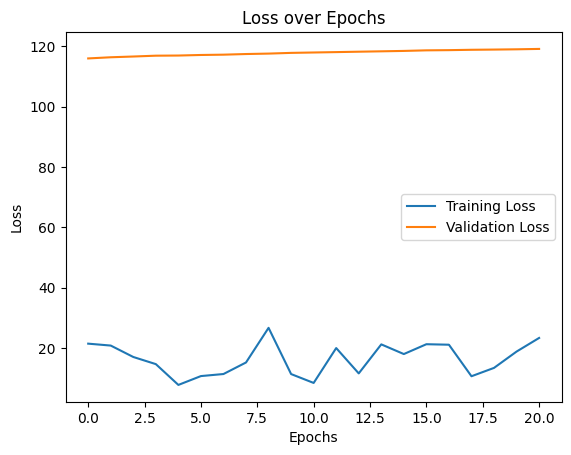

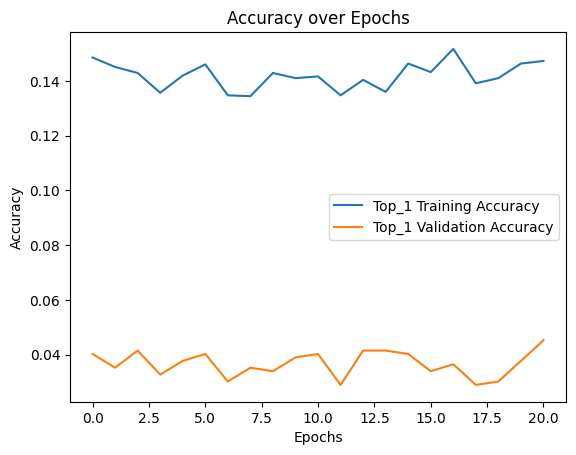

In [71]:
metrics = history.history
plt.plot(metrics['loss'], label='Training Loss')
plt.plot(metrics['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotta l'accuracy di training
plt.plot(metrics['factorized_top_k/top_1_categorical_accuracy'], label='Top_1 Training Accuracy')
plt.plot(metrics['val_factorized_top_k/top_1_categorical_accuracy'], label='Top_1 Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#Training with PCA

In [ ]:
data_tf = tf.data.Dataset.from_tensor_slices({
    "user_id": df_full['UserId'].values.reshape(-1,1),
    "item_id": df_full['ItemId'].values.reshape(-1,1),
    "item_embedding" : df_full[[f'pc_{i}' for i in range(reduced.shape[1])]].values
})

In [ ]:
candidates_tf = tf.data.Dataset.from_tensor_slices({
    "item_id": full_items['ItemId'].values.reshape(-1,1),
    "item_embedding" : full_items[[f'pc_{i}' for i in range(reduced.shape[1])]].values
})
candidates_ds = candidates_tf.batch(32)

Divido in train e test

In [ ]:
data_tf = data_tf.shuffle(buffer_size=1024, seed = 999, reshuffle_each_iteration = False)
full_size = len(data_tf)
train_size = int(full_size * 0.8)
val_size = int(train_size * 0.2)
train_size -= val_size

train = data_tf.take(train_size)
rest = data_tf.skip(train_size)
val = rest.take(val_size)
test = rest.skip(val_size)

In [ ]:
batch_size = 32
train = train.shuffle(buffer_size=1024, seed = 999).batch(batch_size)
test = test.batch(batch_size)
val = val.batch(batch_size)

In [ ]:
for features in train.take(1):
    print("User ID Shape in Train:", features["user_id"].shape)
    print("Item Embedding Shape in Train:", features["item_embedding"].shape)

User ID Shape in Train: (32, 1)
Item Embedding Shape in Train: (32, 95)


In [ ]:
class CFRecommender(tfrs.Model):

  def __init__(self, user_model, item_model, candidates):
    super().__init__()
    self.user_model = user_model
    self.item_model = item_model
    self.task = tfrs.tasks.Retrieval(metrics=tfrs.metrics.FactorizedTopK(
            candidates = candidates.map(self.item_model)))

  def compute_loss(self, features, training = False):
    user_emb = self.user_model(features['user_id'])
    item_emb = self.item_model(features['item_embedding'])
    return self.task(user_emb, item_emb)

In [ ]:
n_components

95

In [ ]:
unique_user_ids = df_full['UserId'].unique().astype(str)
unique_item_ids = df_full['ItemId'].unique().astype(str)
embedding_dim = n_components

user_model = tf.keras.Sequential([
                                  tf.keras.layers.Embedding(input_dim = len(unique_user_ids), output_dim = embedding_dim),
                                  tf.keras.layers.Flatten(),

                                  tf.keras.layers.Dense(6),
                                  tf.keras.layers.ReLU(),
                                  tf.keras.layers.Dense(6),
                                  tf.keras.layers.Flatten(),
                                  ])

item_model = tf.keras.Sequential([tf.keras.Input(shape=(embedding_dim,), dtype=tf.float32, name='item_embedding'),
                                  tf.keras.layers.Dense(6),
                                  tf.keras.layers.ReLU(),
                                  tf.keras.layers.Dense(6)
                                ])

In [ ]:
df_full

,Sku,ItemName,Category,UnitPrice,ItemId,Collection,Availability,Color,Gender,Description,...,pc_91,pc_92,pc_93,pc_94,Id,UserId,CreatedOnUtc,RefundedEUR,UnitPriceTaxEUR,Interaction
0,A20205716614238589,MICRO RHOMBUS STITCH CREW NECK,['Maglieria'],130.0,0,Fall-Winter,0,589,Men,crew neck sweater in pure merino wool with mic...,...,0.022511,-0.062532,-0.008932,0.036174,8812,0,2021-01-01 09:29:05.2513839,0.0,130.0,1
1,A20205716614238589,MICRO RHOMBUS STITCH CREW NECK,['Maglieria'],130.0,0,Fall-Winter,0,589,Men,crew neck sweater in pure merino wool with mic...,...,0.022511,-0.062532,-0.008932,0.036174,8860,47,2021-01-03 23:11:34.9635880,0.0,130.0,1
2,A20205716614238589,MICRO RHOMBUS STITCH CREW NECK,['Maglieria'],130.0,0,Fall-Winter,0,589,Men,crew neck sweater in pure merino wool with mic...,...,0.022511,-0.062532,-0.008932,0.036174,9311,413,2021-02-13 12:39:33.7391675,0.0,130.0,1
3,A20205716614238589,MICRO RHOMBUS STITCH CREW NECK,['Maglieria'],130.0,0,Fall-Winter,0,589,Men,crew neck sweater in pure merino wool with mic...,...,0.022511,-0.062532,-0.008932,0.036174,9772,276,2021-04-10 11:33:22.9952881,0.0,130.0,1
4,A20201312414230005,WAVE PATTERN TURTLENECK,['Maglieria'],160.0,1,Fall-Winter,0,5,Men,turtleneck sweater in pure merino wool embelli...,...,0.072122,0.097351,-0.026363,0.077163,8813,1,2021-01-01 09:39:57.3829465,0.0,160.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19867,A20231312622601465,AIR WOOL TURTLE NECK,['Maglieria'],200.0,3492,Fall-Winter,1,465,Men,air wool turtleneck the special feature of thi...,...,0.055305,-0.089542,0.009496,0.016985,19639,956,2023-10-30 09:41:32.5978041,0.0,200.0,1
19868,A20231312622601661,AIR WOOL TURTLE NECK,['Maglieria'],200.0,3493,Fall-Winter,1,661,Men,air wool turtleneck the special feature of thi...,...,0.055305,-0.089542,0.009496,0.016985,19639,956,2023-10-30 09:41:32.5978041,0.0,200.0,1
19869,A20232311825022098,WOOL JACKET WITH ECO-PADDING,"['Capispalla', 'Maglieria']",460.0,3494,Fall-Winter,1,98,Men,super geelong wool bomber jacket the front is ...,...,0.013882,-0.082032,-0.009291,0.038633,19640,5242,2023-10-30 13:38:18.8120889,1400.0,460.0,-1
19870,A20232312519621039,2-PLY CASHMERE BLEND MOCK ZIP,['Maglieria'],245.0,3495,Fall-Winter,1,39,Men,2ply mock zip sweater cashmere blend an evergr...,...,0.024099,0.041700,0.015320,0.000943,19640,5242,2023-10-30 13:38:18.8120889,1400.0,245.0,-1


In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_factorized_top_k/top_100_categorical_accuracy', patience=10, mode='max')
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model',
    save_best_only=True,
    monitor='val_loss',
    mode='min')

In [ ]:
initial_learning_rate = 0.5
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.999,
    staircase=True)

optimizer = tf.keras.optimizers.Adagrad(learning_rate=lr_schedule)

In [ ]:
recommender = CFRecommender(user_model, item_model, candidates_ds)
recommender.compile(optimizer = optimizer)

In [ ]:
history = recommender.fit(train,
                validation_data = val,
                epochs=100)

Epoch 1/100
398/398 [==============================] - 36s 91ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0506 - factorized_top_k/top_5_categorical_accuracy: 0.0532 - factorized_top_k/top_10_categorical_accuracy: 0.0578 - factorized_top_k/top_50_categorical_accuracy: 0.0972 - factorized_top_k/top_100_categorical_accuracy: 0.1470 - loss: 95.6810 - regularization_loss: 0.0000e+00 - total_loss: 95.6810 - val_factorized_top_k/top_1_categorical_accuracy: 0.0456 - val_factorized_top_k/top_5_categorical_accuracy: 0.0462 - val_factorized_top_k/top_10_categorical_accuracy: 0.0478 - val_factorized_top_k/top_50_categorical_accuracy: 0.0591 - val_factorized_top_k/top_100_categorical_accuracy: 0.0859 - val_loss: 27.2782 - val_regularization_loss: 0.0000e+00 - val_total_loss: 27.2782
Epoch 2/100
398/398 [==============================] - 36s 91ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0549 - factorized_top_k/top_5_categorical_accuracy: 0.0578 - factorized_top_k/top_10_cate

In [ ]:
metrics = history.history
plt.plot(metrics['loss'], label='Training Loss')
plt.plot(metrics['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotta l'accuracy di training
plt.plot(metrics['factorized_top_k/top_1_categorical_accuracy'], label='Top_1 Training Accuracy')
plt.plot(metrics['val_factorized_top_k/top_1_categorical_accuracy'], label='Top_1 Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
recommender.evaluate(test)

125/125 [==============================] - 9s 71ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0101 - factorized_top_k/top_5_categorical_accuracy: 0.0133 - factorized_top_k/top_10_categorical_accuracy: 0.0199 - factorized_top_k/top_50_categorical_accuracy: 0.0282 - factorized_top_k/top_100_categorical_accuracy: 0.0410 - loss: 180.6875 - regularization_loss: 0.0000e+00 - total_loss: 180.6875


[0.01006289292126894,
 0.013333333656191826,
 0.01987421326339245,
 0.02817610092461109,
 0.041006289422512054,
 69.03236389160156,
 0,
 69.03236389160156]

#Test

In [71]:
brute_force = tfrs.layers.factorized_top_k.BruteForce(user_model)

brute_force.index_from_dataset(candidates_tf.batch(100).map(lambda id, embedding : (id,embedding)))
accuracy = brute_force.evaluate(test)


TypeError: ignored

#Tuning dei parametri

In [79]:
class HyperRecommender(HyperModel):
  def __init__(self, user_input_dim, item_input_dim, embedding_dim, candidates_ds):
    self.user_input_dim = user_input_dim
    self.item_input_dim = item_input_dim
    self.embedding_dim = embedding_dim
    self.candidates_ds = candidates_ds

  def build(self, hp):
    unique_user_ids = df_full['UserId'].unique().astype(str)
    unique_item_ids = df_full['ItemId'].unique().astype(str)
    embedding_dim = df_embeddings.shape[1]-1
    user_model = tf.keras.Sequential([
                                  tf.keras.layers.Embedding(input_dim = len(unique_user_ids), output_dim = embedding_dim),
                                  #tf.keras.layers.Flatten(),
                                  tf.keras.layers.Dense(hp.Int("dense_size", min_value=2, max_value=32, step=2)),
                                  #tf.keras.layers.ReLU(),
                                  tf.keras.layers.Dense(hp.Int("dense_size", min_value=2, max_value=32, step=2)),
                                  tf.keras.layers.Flatten(),
                                  ])
    item_model = tf.keras.Sequential([tf.keras.Input(shape=(embedding_dim,), dtype=tf.float32, name='item_embedding'),
                                  #tf.keras.layers.Dense(6),
                                  #tf.keras.layers.ReLU(),
                                  tf.keras.layers.Dense(hp.Int("dense_size", min_value=2, max_value=32, step=2))
                                ])

    # Define the CFRecommender model
    model = CFRecommender(user_model, item_model, self.candidates_ds)

    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adagrad(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=6e-1, sampling='LOG')),
    )

    return model

In [80]:
hypermodel = HyperRecommender(user_input_dim = len(unique_user_ids),
                              item_input_dim = embedding_dim,
                              embedding_dim = embedding_dim,
                              candidates_ds = candidates_ds)


In [81]:
tuner = RandomSearch(hypermodel,
                     objective = 'val_loss',
                     max_trials = 50,
                     directory = 'keras_tuner_dir',
                     project_name = 'gs_recommender')

/usr/local/lib/python3.10/dist-packages/keras/engine/functional.py:639: UserWarning: Input dict contained keys ['item_id'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


In [ ]:
tuner.search_space_summary()
tuner.search(train, validation_data=val, epochs=20, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)])

Trial 46 Complete [00h 00m 52s]
val_loss: 96.96022033691406

Best val_loss So Far: 84.05010986328125
Total elapsed time: 00h 55m 42s

Search: Running Trial #47

Value             |Best Value So Far |Hyperparameter
28                |30                |dense_size
0.00013064        |0.048752          |learning_rate

Epoch 1/20
100/100 [==============================] - 8s 74ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 9.4221e-04 - factorized_top_k/top_10_categorical_accuracy: 0.0057 - factorized_top_k/top_50_categorical_accuracy: 0.0509 - factorized_top_k/top_100_categorical_accuracy: 0.0983 - loss: 109.5958 - regularization_loss: 0.0000e+00 - total_loss: 109.5958 - val_factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - val_factorized_top_k/top_5_categorical_accuracy: 0.0038 - val_factorized_top_k/top_10_categorical_accuracy: 0.0126 - val_factorized_top_k/top_50_categorical_accuracy: 0.0440 - val_factorized_top_k/

In [83]:
best_hyperparams = tuner.get_best_hyperparameters(num_trials=1)[0]
for hparam in best_hyperparams.values:
  print(f'{hparam}: {best_hyperparams.get(hparam)}')

dense_size: 30
learning_rate: 0.04875167591835013


In [84]:
best_model = tuner.hypermodel.build(best_hyperparams)
best_history = best_model.fit(train, validation_data=val, epochs=100)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/engine/functional.py:639: UserWarning: Input dict contained keys ['item_id'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


100/100 [==============================] - 9s 76ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0408 - factorized_top_k/top_5_categorical_accuracy: 0.0556 - factorized_top_k/top_10_categorical_accuracy: 0.0726 - factorized_top_k/top_50_categorical_accuracy: 0.1932 - factorized_top_k/top_100_categorical_accuracy: 0.2780 - loss: 108.1068 - regularization_loss: 0.0000e+00 - total_loss: 108.1068 - val_factorized_top_k/top_1_categorical_accuracy: 0.0063 - val_factorized_top_k/top_5_categorical_accuracy: 0.0201 - val_factorized_top_k/top_10_categorical_accuracy: 0.0289 - val_factorized_top_k/top_50_categorical_accuracy: 0.1168 - val_factorized_top_k/top_100_categorical_accuracy: 0.1985 - val_loss: 97.2494 - val_regularization_loss: 0.0000e+00 - val_total_loss: 97.2494
Epoch 2/100
100/100 [==============================] - 7s 71ms/step - factorized_top_k/top_1_categorical_accuracy: 0.1052 - factorized_top_k/top_5_categorical_accuracy: 0.1451 - factorized_top_k/top_10_categorical_accu

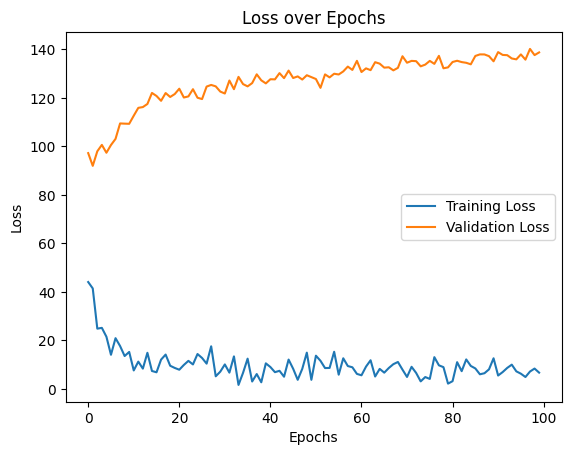

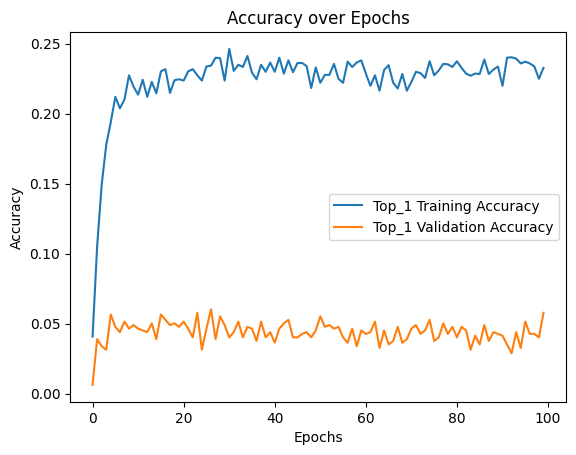

In [85]:
metrics = best_history.history
plt.plot(metrics['loss'], label='Training Loss')
plt.plot(metrics['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotta l'accuracy di training
plt.plot(metrics['factorized_top_k/top_1_categorical_accuracy'], label='Top_1 Training Accuracy')
plt.plot(metrics['val_factorized_top_k/top_1_categorical_accuracy'], label='Top_1 Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [86]:
best_model.evaluate(test )

32/32 [==============================] - 2s 64ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0342 - factorized_top_k/top_5_categorical_accuracy: 0.0543 - factorized_top_k/top_10_categorical_accuracy: 0.0744 - factorized_top_k/top_50_categorical_accuracy: 0.1829 - factorized_top_k/top_100_categorical_accuracy: 0.2312 - loss: 147.2241 - regularization_loss: 0.0000e+00 - total_loss: 147.2241


[0.03417085483670235,
 0.054271355271339417,
 0.07437185943126678,
 0.18291456997394562,
 0.23115578293800354,
 18.794763565063477,
 0,
 18.794763565063477]

#Raccomandazioni per utente e per articolo

In [89]:
candidates_embeddings = item_model.predict(df_embeddings.values[:, :-1])
candidate_item_ids = full_items['ItemId'].values

31/31 [==============================] - 0s 1ms/step


In [90]:
def user_recommendations(user_id, user_model, item_model, candidates,candidates_ids, k=5):
  user_id_tensor = tf.convert_to_tensor([[user_id]])
  user_embedding = user_model(user_id_tensor)
  scores = tf.matmul(user_embedding, candidates, transpose_b=True)
  top_k_indices = tf.math.top_k(scores, k=k).indices.numpy().flatten()
  return [candidates_ids[i] for i in top_k_indices]

In [91]:
uid = customers[customers['CustomerId']== 91311]['UserId']
recommendation_ids = user_recommendations(uid.iloc[0], user_model, item_model, candidates_embeddings, candidate_item_ids,3)
items[items['ItemId'].isin(recommendation_ids)]

,index,Sku,ItemName,Category,UnitPrice,ItemId,Collection,Availability,Color,Gender,Description,Composition,TextInfo
289,2808,P20235710418017510,ORGANIC COTTON RAGLAN T-SHIRT,"['Polo, Camicie e T-shirt']",135.25,2808,Spring-Summer,1,510,Men,organic cotton short raglan sleeve tshirt both...,cotton,organic cotton raglan t-shirt organic cotton s...
313,2832,P20235710418017005,ORGANIC COTTON RAGLAN T-SHIRT,"['Polo, Camicie e T-shirt']",135.25,2832,Spring-Summer,1,5,Men,organic cotton short raglan sleeve tshirt both...,cotton,organic cotton raglan t-shirt organic cotton s...
314,2833,P20235710418017580,ORGANIC COTTON RAGLAN T-SHIRT,"['Polo, Camicie e T-shirt']",165.00,2833,Spring-Summer,1,580,Men,organic cotton short raglan sleeve tshirt both...,cotton,organic cotton raglan t-shirt organic cotton s...


In [95]:
def similar_items(item_id, item_model, candidates_embeddings,candidates_ids,embedding_dim, k=5):
  input = df_embeddings.iloc[item_id].values[:embedding_dim].reshape(1, -1)
  item_embedding = item_model.predict(input)
  scores = tf.matmul(item_embedding, candidates_embeddings.T)
  top_k_indices = tf.math.top_k(scores, k=k+1).indices.numpy().flatten()
  top_k_indices = top_k_indices[top_k_indices != item_id]
  return [candidates_ids[i] for i in top_k_indices[:k]]

In [96]:
item_id = 0
similar_to = similar_items(item_id, item_model, candidates_embeddings, candidate_item_ids,embedding_dim, k=5)
items[items['ItemId'].isin(similar_to)]

1/1 [==============================] - 0s 21ms/step


,index,Sku,ItemName,Category,UnitPrice,ItemId,Collection,Availability,Color,Gender,Description,Composition,TextInfo
68,2583,P20235716918622570,STRIPED KNIT T-SHIRT,"['Polo, Camicie e T-shirt']",175.00,2583,Spring-Summer,1,570,Men,linen and cotton knit tshirt the contrasting h...,linen,striped knit t-shirt linen and cotton knit tsh...
128,2644,P20235716918622336,STRIPED KNIT T-SHIRT,"['Polo, Camicie e T-shirt']",175.00,2644,Spring-Summer,1,336,Men,linen and cotton knit tshirt the contrasting h...,linen,striped knit t-shirt linen and cotton knit tsh...
287,2806,P20235716918622016,STRIPED KNIT T-SHIRT,"['Polo, Camicie e T-shirt']",175.00,2806,Spring-Summer,1,16,Men,linen and cotton knit tshirt the contrasting h...,linen,striped knit t-shirt linen and cotton knit tsh...
951,3470,A20231313715702110,ECO CASHMERE MOULINE' HOODED FULL ZIP,"['Cashmere', 'Maglieria']",1030.92,3470,Fall-Winter,1,110,Men,mouliné effect purl knit 3ply eco cashmere hoo...,cashmere,eco cashmere mouline' hooded full zip mouliné ...
952,3471,A20232312115561001,CASHMERE RIBBED GILET,"['Cashmere', 'Maglieria']",984.48,3471,Fall-Winter,1,1,Men,pure cashmere ribbed gilet alcantara details f...,cashmere,cashmere ribbed gilet pure cashmere ribbed gil...


In [99]:
items.iloc[0]

index                                                        2112
Sku                                            P20236013374002598
ItemName                                MERCERIZED COTTON T-SHIRT
Category                              ['Polo, Camicie e T-shirt']
UnitPrice                                                   110.0
ItemId                                                       2112
Collection                                          Spring-Summer
Availability                                                    1
Color                                                         598
Gender                                                        Men
Description     mercerized cotton thread tshirt this cotton je...
Composition                                                cotton
TextInfo        mercerized cotton t-shirt mercerized cotton th...
Name: 0, dtype: object

#Cross Network Model
